In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline
#%run ./two-histograms.ipynb

## BACKGROUND

To create a model that uses data from the first 24 hours of intensive care to predict patient survival.

MIT's GOSSIS community initiative, with privacy certification from the Harvard Privacy Lab, has provided a dataset of more than 130,000 hospital Intensive Care Unit (ICU) visits from patients, spanning a one-year timeframe. This data is part of a growing global effort and consortium spanning Argentina, Australia, New Zealand, Sri Lanka, Brazil, and more than 200 hospitals in the United States.

[WiDS2020](https://www.widsconference.org/datathon.html)

**29/02/2020: Answers to some of the data questions:**
* [Negative pre_icu_los_days](https://www.kaggle.com/c/widsdatathon2020/discussion/127764#729694) - from the data stewards: the values for preiculos_days are calculated using administrative data, so sometimes there are negative numbers (that's another way you can appreciate that this data is real!). "It doesn't mean anything special other than it is probably incorrect."
* [Value of -1 in `apache_4a_hospital_death_prob` AND `apache_4a_icu_death_prob`](https://www.kaggle.com/c/widsdatathon2020/discussion/127698) - -1 means the score couldn't be calculated for some reason.  In this particular dataset, it's more likely that these patient encounters have a variable missing from the APACHE-IVa equation

## 1. Load the dataset

In [2]:
train = pd.read_csv('../data/training_v2.csv')
print(train.shape)

(91713, 186)


> training file has 186 columns, with 91713 entries

In [3]:
pd.set_option('display.max_columns', 200)

In [4]:
train.head(10)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

## 2. Data Explanation
-----
Based on understandings gathered from the data dictionary and online research, here is a summary.

Explanation:
* `h1`: measurement taken during the first hour of patient's stay in ICU
* `d1`: measurement taken during the first 24 hours of patient's stay in ICU

There are 4 groups of measurements:
1. vitals, 
2. APACHE scores
2. labs, 
3. arterial blood gas test

There are 15 binary columns,  8 categorical columns. Majority are numerical.

### The columns can be grouped in the following way:
|Categories | Number of columns| What/When to measure |
|-----|-----|-----|
| Identifier | 4|encounter_id,hospital_id, patient_id, icu_id|
| Demographic | 15||
| APACHE | 40 ||
| h1_vitals| 26 |Each contains min and max.  diastolic/systolic blood pressure (12, invasive, noninvasive, general?)|
|||                 mbp-mean blood pressure(6, invasive/noninvasive, general?)|
|||                 resprate rate (2), spo2 - peripheral oxygen saturation (2), core temperature (2)        |
| d1_vitals| 26 |(same as h1_vitals)|
|h1_labs | 30 |Each contains min and max.  albumin, bilirubin, blood urea nitrogen(bun), calcium, creatinine, glucose, bicarbonate(hco3),hemaglobin, volume proportion of red blood cells (hematocrit), international normalized ratio (inr), lactate, platelets, potassium, sodium, white blood cell counts (wbs)|
|d1_labs | 30 | (same as h1_labs)|
| h1_lab_blood_gas | 8 |partial pressure of carbon dioxide, arterial pH, arterial partial pressure of oxygen and fraction of inspired oxygen|
| d1_lab_blood_gas | 8 |(same as above)|

### APACHE
The Acute Physiology and Chronic Health Evaluation (APACHE) severity of disease classification system, which is one of the most widely used scoring systems to predict mortality, is used for intensive care units (ICU) patients.

The worse values obtained during the first 24hrs is used.

Apache 2(1985) is widely accepted and used in ICU.  Apache 3 is an update version with a score (ranged from 0-299) and apredictive equation for hosptial mortality.  Apache 3 use the same variabels as Apache 2 with some changes:
1. 2 new variables added: patient origin, and lead-time bias
2. Acute diagnosis is taken into account.  One diagnosis must be preferred.
3. No longer using GCS (used in Apache 2, but we have GCS scores in the data)

Apache 3 contains the following:
1. 18 physiological variables (apache covariate in our data contain 22: 18 + 4 indicators)
2. Age
3. chronic health status (8 is seenin our data)

According to Apache 2, if a variable has not been measured, a zero should be assigned to it.

Apache 3j is an international gold standard for ICU, developed in 2002.https://www.cicm.org.au/CICM_Media/CICMSite/CICM-Website/Resources/Publications/CCR%20Journal/Previous%20Editions/March%202014/02_2014_Mar_Edit-The-Australian-and-New.pdf

### Arterial Blood Gas Test 

* It is ordered for patients with **breathing problems, lung diseases,or acid-base balance issue** (due to kidney failure, a severe infection, specific toxic ingestions, complications of diabetes (DKA), or under-treated sleep apnea) 
* Differet from other blood test, sample is drawn from an **artery** instead of a vein in your groin or your wrist.
* It measures oxygen and carbon dioxide levels in your blood. It also measures your body’s acid-base (pH) level, which is usually in balance when you’re healthy.

https://www.webmd.com/lung/arterial-blood-gas-test#1 

### Create column list for different categories

In [5]:
demographic = ['hospital_death','age','bmi','weight','height','elective_surgery','ethnicity','gender','hospital_id','hospital_admit_source',
'icu_admit_source','icu_id','icu_stay_type','icu_type','pre_icu_los_days']

# APACHE related measurements
# ---
# 18 measurements
apache_cov = ['albumin_apache','bilirubin_apache','bun_apache','creatinine_apache','glucose_apache','heart_rate_apache',
          'hematocrit_apache','resprate_apache','sodium_apache','temp_apache','urineoutput_apache','wbc_apache',
          'fio2_apache','map_apache','paco2_apache','paco2_for_ph_apache','pao2_apache','ph_apache']
# 4 indicators
apache_indicators = ['apache_post_operative','arf_apache','intubated_apache','ventilated_apache']

# 8 Chronic health status
apache_chronic = ['aids','cirrhosis','diabetes_mellitus','hepatic_failure',
                  'immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']
# 6 others
apache_others =['apache_2_diagnosis','apache_3j_diagnosis', 'apache_3j_bodysystem','apache_2_bodysystem',
                'apache_4a_hospital_death_prob','apache_4a_icu_death_prob']

gcs = ['gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache']

apache = apache_cov + apache_indicators + apache_chronic + apache_others + gcs
# ---

vitals_names = ['diasbp_invasive','diasbp','diasbp_noninvasive','sysbp_invasive', 'sysbp', 'sysbp_noninvasive', 
                'mbp_invasive', 'mbp', 'mbp_noninvasive','heartrate','resprate' ,'spo2', 'temp']
labs_names = ['albumin','bilirubin', 'bun','calcium', 'creatinine', 'glucose', 'hco3', 'hemaglobin','hematocrit','inr',
        'lactate',  'platelets','potassium', 'sodium', 'wbc']

vitals = ['diasbp_invasive_max','diasbp_invasive_min','diasbp_max','diasbp_min','diasbp_noninvasive_max', 'diasbp_noninvasive_min', 
          'sysbp_invasive_max','sysbp_invasive_min','sysbp_max','sysbp_min', 'sysbp_noninvasive_max','sysbp_noninvasive_min',
          'mbp_invasive_max', 'mbp_invasive_min', 'mbp_max', 'mbp_min','mbp_noninvasive_max', 'mbp_noninvasive_min', 
          'heartrate_max','heartrate_min','resprate_max','resprate_min','spo2_max','spo2_min','temp_max','temp_min']

labs = ['albumin_max', 'albumin_min', 'bilirubin_max' ,'bilirubin_min', 'bun_max',
 'bun_min', 'calcium_max', 'calcium_min', 'creatinine_max', 'creatinine_min',
 'glucose_max', 'glucose_min', 'hco3_max' ,'hco3_min', 'hemaglobin_max',
 'hemaglobin_min' ,'hematocrit_max', 'hematocrit_min' ,'inr_max' ,'inr_min',
 'lactate_max', 'lactate_min', 'platelets_max', 'platelets_min',
 'potassium_max' ,'potassium_min', 'sodium_max', 'sodium_min', 'wbc_max',
 'wbc_min']

# Arterial blood gas test
lab_blood_gas = ['arterial_pco2_max', 'arterial_pco2_min', 'arterial_ph_max', 'arterial_ph_min', 
                 'arterial_po2_max', 'arterial_po2_min', 'pao2fio2ratio_max', 'pao2fio2ratio_min']

print("The number of columns for demographic: ",len(demographic))
print("The number of columns for vitals: ",len(vitals))
print("The number of columns for lab tests: ",len(labs))
print("The number of columns for vitals_names: ",len(vitals_names)) 
print("The number of columns for labsnames: ",len(labs_names))
print("The number of columns for arterial blood gas test: ",len(lab_blood_gas))
print("The number of columns for Glasgow Coma Score: ",len(gcs))
print("The number of columns for APACHE 3 measurements: ",len(apache_cov))
print("The number of columns for APACHE Chronic Health Status: ",len(apache_chronic))
print("The number of columns for other APACHE measurements: ",len(apache_others))
print("Total number of columns for APACHE: ",len(apache))

h1_vitals = ['h1_'+name for name in vitals]
d1_vitals = ['d1_'+name for name in vitals]
h1_labs = ['h1_'+name for name in labs]
d1_labs = ['d1_'+name for name in labs]
h1_lbg = ['h1_'+name for name in lab_blood_gas]
d1_lbg = ['d1_'+name for name in lab_blood_gas]

total = set(demographic + apache + h1_vitals + d1_vitals + h1_labs + d1_labs + h1_lbg + d1_lbg)
print("Total number of columns: ",len(total))

The number of columns for demographic:  15
The number of columns for vitals:  26
The number of columns for lab tests:  30
The number of columns for vitals_names:  13
The number of columns for labsnames:  15
The number of columns for arterial blood gas test:  8
The number of columns for Glasgow Coma Score:  4
The number of columns for APACHE 3 measurements:  18
The number of columns for APACHE Chronic Health Status:  8
The number of columns for other APACHE measurements:  6
Total number of columns for APACHE:  40
Total number of columns:  183


In [6]:
print(train.columns.difference(total))
print(total.difference(train.columns))

Index(['encounter_id', 'patient_id', 'readmission_status'], dtype='object')
set()


## 2. Basic EDA

In [7]:
# Check duplicate entry
train.encounter_id.unique().shape, train.patient_id.unique().shape, train.hospital_id.unique().shape

# Every row is an unique entry(unique encounter_id, and unique patient_id)
# No duplicates seen

((91713,), (91713,), (147,))

In [8]:
# Another way to check for duplicates - look for same patient_id with more than one rows
train.duplicated(subset=['patient_id'], keep=False).unique()

array([False])

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


>There are 186 columns, not able to view all by info()

### Check datatype

In [10]:
# Categorical columns
categorical_cols = [col for col in train.columns if  (train[col].dtype != 'float64')&(train[col].dtype != 'int64') ]
print(len(categorical_cols))
categorical_cols

# 8 categorical columns

8


['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [11]:
# Integer columns
int_cols = [col for col in train.columns if  train[col].dtype == 'int64' ]
print(len(int_cols))
int_cols

8


['encounter_id',
 'patient_id',
 'hospital_id',
 'hospital_death',
 'elective_surgery',
 'icu_id',
 'readmission_status',
 'apache_post_operative']

> ID should be treated as string, intead of integer. 

> In our case, enounter_id and patient_id are to identify patient, have no significance in the mortality prediction.  Can be removed safely. 

> hospital_id and icu_id will be converted to string and leave them for the time being for EDA

In [12]:
# float columns
float_cols = [col for col in train.columns if  train[col].dtype == 'float64' ]
print(len(float_cols))
float_cols

# binary col: 'arf_apache','gcs_unable_apache','intubated_apache',ventilated_apache'
#              'aids','cirrhosis','diabetes_mellitus','hepatic_failure', 'immunosuppression',
#              'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
# Leave it as it is now

170


['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_invasive_m

### Check Numerical columns' count and distribution

In [13]:
train.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,91713.0,88993.000000,37334.000000,90051.000000,90612.000000,91713.000000,90998.000000,33579.000000,72451.00000,72860.000000,20845.000000,89812.000000,89812.000000,90676.000000,89812.000000,80677.000000,90835.000000,71835.000000,90998.000000,90719.000000,20845.000000,20845.000000,20845.000000,20845.000000,90479.000000,73113.000000,87605.000000,42715.000000,90998.000000,69701.000000,23729.000000,23729.000000,91548.000000,91548.000000,90673.000000,90673.000000,91568.000000,91568.000000,23936.000000,23936.000000,91493.000000,91493.000000,90234.000000,90234.000000,91328.000000,91328.000000,91380.000000,91380.000000,23754.000000,23754.000000,91554.000000,91554.00000,90686.000000,90686.000000,89389.000000,89389.000000,16785.000000,16785.000000,88094.000000,88094.000000,84363.000000,84363.000000,88923.000000,88923.000000,16869.000000,16869.000000,87074.000000,87074.000000,82629.000000,82629.000000,87356.000000,87356.000000,87528.000000,87528.000000,16798.000000,

#### Observations:
* pre_icu_los_days have negative value, there are outliers too (extremely large values).  This columns is in number of days, negative values don't make sense.  Convert this column to be in the unit of hours?  based on reserach, usually the time between hosptial admission and ICU admission is measured in hours. http://wfccn.org/wp-content/uploads/2018/02/Triage-in-ICU-JCC-2016.pdf
* readmission_status is all zero - can be removed
* weight: min 38.6kgs, max 186kgs, are these normal?
* height: min 137.2, max 195.59cm
* bmi: min 14.8, max 67.81 - verify these readyings later, missing bmi can be calculated from weight and height

* apache_2_diagnosis, apache_3j_diagnosis - wrong datatype, they should be string. Will keep them as numeric for now for feature engineering

* all the test results - need to understand before knowing if the readings are correct

* apache_4a_hospital_death_prob, apache_4a_icu_death_prob have negative value - wrong. probability is between (0,1)

Column of wrong datatype - to fix
Columns with constant value (nunique() = 1) - to remove
columns with high percentage of missing value - to remove
Missing data - impute or remove (row-wise, or column-wise)
Abnormal data - fix or remove

### A quick look at the amount of missing data

In [14]:
np.round(train.isnull().mean()*100,2)

# Not able to display all columns, use visualisation to help

encounter_id                   0.00
patient_id                     0.00
hospital_id                    0.00
hospital_death                 0.00
age                            4.61
                               ... 
leukemia                       0.78
lymphoma                       0.78
solid_tumor_with_metastasis    0.78
apache_3j_bodysystem           1.81
apache_2_bodysystem            1.81
Length: 186, dtype: float64

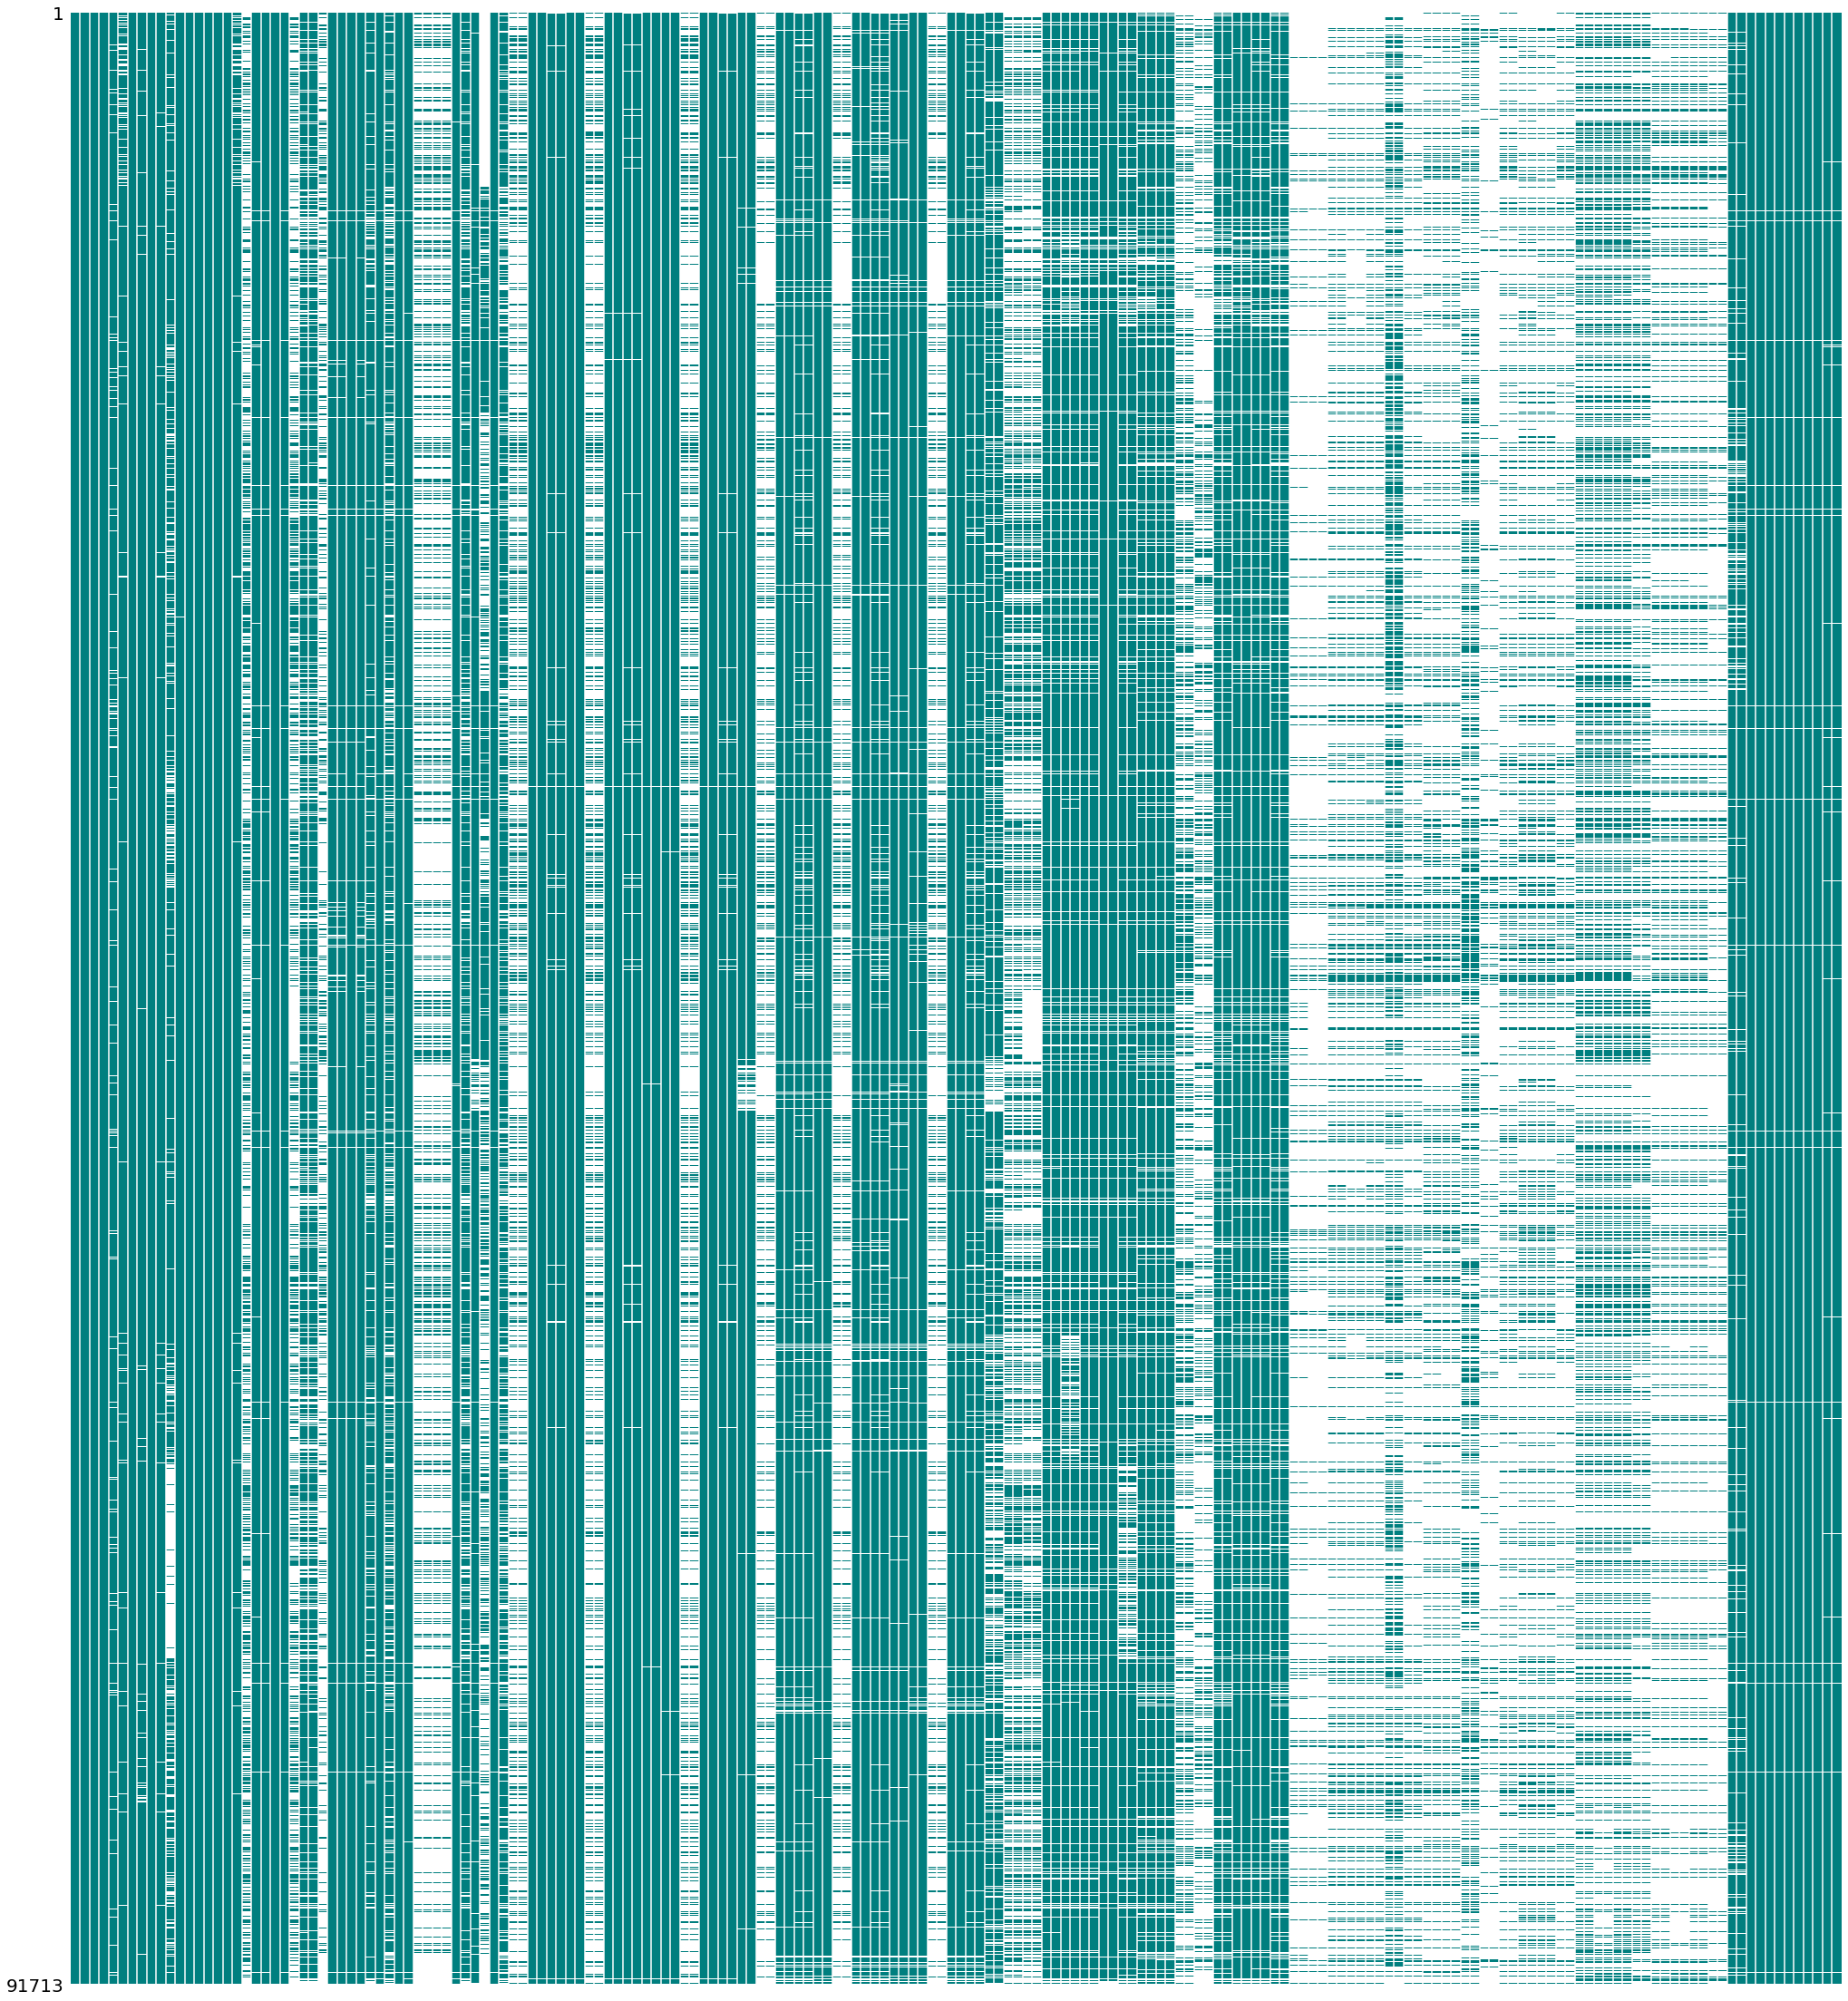

In [15]:
msno.matrix(train,figsize=(35, 40), width_ratios=(10, 1), color=(.0, 0.5, 0.5),fontsize=16,sparkline=False)
#msno.matrix(test,figsize=(35, 40), width_ratios=(10, 1), color=(.80, 0.5, 0.5),sparkline=False)

### Look for constant columns

In [16]:
[col for col in train.columns if train[col].nunique() == 1]

# only one column has constant value, will drop it as it has no effects on prediction

['readmission_status']

In [17]:
train.readmission_status.value_counts()

0    91713
Name: readmission_status, dtype: int64

### This is an unbalanced class problem - Hosptial death at 8.6%

In [18]:
print(train.hospital_death.value_counts())
print()
print(train.hospital_death.value_counts(normalize=True))

0    83798
1     7915
Name: hospital_death, dtype: int64

0    0.913698
1    0.086302
Name: hospital_death, dtype: float64


## 3. Create dataframe for further EDA

In [19]:
df = train.drop(columns=['encounter_id','patient_id','readmission_status']).reset_index(drop=True)
df.hospital_id = df.hospital_id.astype(str)
df.icu_id = df.icu_id.astype(str)
#df.apache_2_diagnosis = df.apache_2_diagnosis.astype(str)
#df.apache_3j_diagnosis = df.apache_3j_diagnosis.astype(str)
print(df.shape)
df.head(10)

(91713, 183)


,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,

In [20]:
# to confirm the columns are of the right datatype
categorical_cols = [col for col in df.columns if  (df[col].dtype != 'float64')&(df[col].dtype != 'int64') ]
print(len(categorical_cols))
categorical_cols

# Now ther are 10 categorical columns

10


['hospital_id',
 'ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

## 4. Data Cleaning and EDA
Approach:
* Abnormal Data
* Missing Data
   * Impute
   * zero
   
Key Points:
* Abnormal data: there are 778 and 2000+ rows of negative values in the train data.  As both train and test show the same issue (negative values), would rather keep them as it as, than imputing them
*
   

### 4.1 Abnormal data
#### 1. Negative pre_icu_los_days 

In [21]:
df[df.pre_icu_los_days<0]

# 778 of patients with negative LOS days.
# Where do these patients come from? What is the ICU type they stayed?

,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
294,83,0,74.0,44.370252,0,Caucasian,F,149.90,Emergency Department,Accident & Emergency,95,admit,Med-Surg ICU,-0.132639,99.70,NaN,110.0,104.01,0,0.0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,193.0,65.0,NaN,0.0,108.0,NaN,NaN,NaN,NaN,48.0,NaN,37.7,NaN,0.0,NaN,NaN,NaN,80.0,56.0,80.0,56.0,84.0,60.0,NaN,NaN,108.0,91.0,108.0,91.0,38.0,16.0,98.0,92.0,NaN,NaN,179.0,132.0,179.0,132.0,38.2,36.7,NaN,NaN,70.0,60.0,70.0,60.0,73.0,65.0,NaN,NaN,108.0,108.0,108.0,108.0,31.0,20.0,97.0,94.0,NaN,NaN,165.0,143.0,165.0,143.0,38.2,37.7,NaN,NaN,NaN,NaN,71.0,71.0,8.7,8.7,3.21,3.21,240.0,155.0,23.0,23.0,9.8,9.8,32.3,32.3,3.8,3.8,NaN,NaN,157.0,157.0,4.5,4.5,136.0,136.0,13.50,13.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,Cardiovascular,Cardiovascular
310,118,0,73.0,NaN,0,Caucasian,M,167.60,Direct Admit,Accident & Emergency,114,admit,CCU-CTICU,-0.215278,NaN,NaN,110.0,

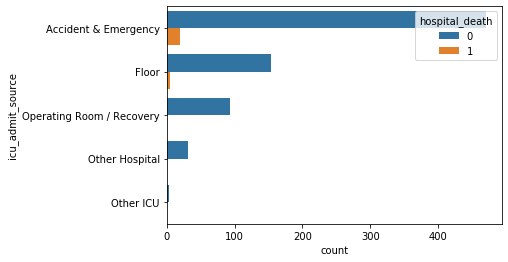

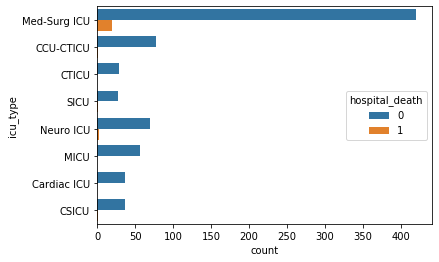

In [22]:
sns.countplot(y=df[df.pre_icu_los_days<0].icu_admit_source, hue=df.hospital_death)
plt.show()
sns.countplot(y=df[df.pre_icu_los_days<0].icu_type, hue=df.hospital_death)

# Majority comes from A&E, staying in the Med-Surg ICU
# Without admission date details, can't correct these.
# Since Test dataset shows the same issue -  will leave it as it is

-24.94722222


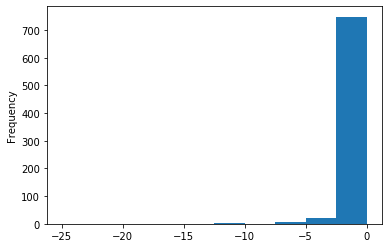

In [23]:
print(df.pre_icu_los_days.min())
df.pre_icu_los_days[df.pre_icu_los_days<0].plot.hist()

#### 2. Extremely large pre_icu_los_days 

In [24]:
df.pre_icu_los_days.quantile(0.99)

10.86027777720003

In [25]:
print(df[df.pre_icu_los_days > df.pre_icu_los_days.quantile(0.99)].shape)   
print(df[df.pre_icu_los_days > 60].shape)

df[df.pre_icu_los_days > 60]

# at 99%tile (10.86 days), there are 918 entries
# Look at the outliers, who have been staying in the hospital for more than 60 days


(918, 183)
(10, 183)


,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
17409,98,0,60.0,34.833210,0,African American,M,182.88,Emergency Department,Accident & Emergency,267,admit,Med-Surg ICU,62.647917,116.5,NaN,109.0,108.01,0,1.0,NaN,NaN,NaN,NaN,4.0,4.0,0.0,4.0,75.0,123.0,NaN,0.0,57.0,NaN,NaN,NaN,NaN,10.0,NaN,36.6,0.0000,0.0,NaN,NaN,NaN,101.0,61.0,101.0,61.0,119.0,94.0,NaN,NaN,119.0,68.0,119.0,68.0,22.0,10.0,100.0,97.0,NaN,NaN,182.0,88.0,182.0,88.0,37.2,36.6,NaN,NaN,101.0,95.0,101.0,95.0,107.0,107.0,NaN,NaN,117.0,109.0,117.0,109.0,12.0,10.0,100.0,100.0,NaN,NaN,171.0,164.0,171.0,164.0,37.1,37.1,3.1,3.1,0.7,0.7,28.0,28.0,9.6,9.6,7.76,7.76,132.0,75.0,27.0,27.0,10.4,10.4,33.6,33.6,1.20,1.20,NaN,NaN,194.0,194.0,3.8,3.8,136.0,136.0,5.00,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.20,1.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,0.09,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
37044,70,0,55.0,32.543618,0,Caucasian,F,165.00,Floor,Floor,434,admit,MICU,73.022917,88.6,NaN,30

#### 3. Negative apache_4a_hospital_death_prob, apache_4a_icu_death_prob

There are 2692 rows of data with negative probability values.

These two probabilites are calculated based on APACHE IV scoring system.

Since Test dataset shows the same issue -  will leave it as it is

In [26]:
print(df[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob']].isnull().sum())
print(df[df.apache_4a_hospital_death_prob<0]['apache_4a_hospital_death_prob'].value_counts())
print(df[df.apache_4a_icu_death_prob<0]['apache_4a_icu_death_prob'].value_counts())

# There are 2692 rows of data with negative values, and they are all -1.  suspect they are proxy for NaN.
# will convert them to NaN to avoid confusion
df.loc[df.apache_4a_hospital_death_prob<0,'apache_4a_hospital_death_prob'] = np.nan
df.loc[df.apache_4a_icu_death_prob<0,'apache_4a_icu_death_prob'] = np.nan

print(df[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob']].isnull().sum())

apache_4a_hospital_death_prob    7947
apache_4a_icu_death_prob         7947
dtype: int64
-1.0    2371
Name: apache_4a_hospital_death_prob, dtype: int64
-1.0    2230
Name: apache_4a_icu_death_prob, dtype: int64
apache_4a_hospital_death_prob    10318
apache_4a_icu_death_prob         10177
dtype: int64


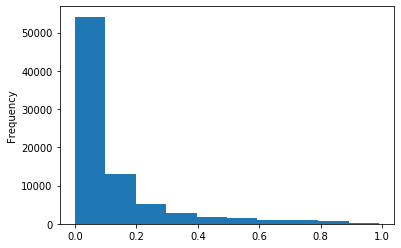

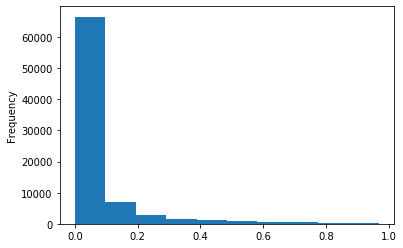

In [27]:
df.apache_4a_hospital_death_prob.plot.hist()
plt.show()
df.apache_4a_icu_death_prob.plot.hist()

## 4.2 Missing Data

In [28]:
col_null = df.isnull().sum().sort_values(ascending=False)
col_null = col_null[col_null>0]
col_null.shape

(175,)

> 175 out of 186 columns contain Null values.  

### Since most of the columns contains missing data, then Which columns are fulling populated?

In [29]:
col_full = df.count()
col_full = col_full[col_full == 91713]
print(col_full.shape)
print(col_full)

(8,)
hospital_id              91713
hospital_death           91713
elective_surgery         91713
icu_id                   91713
icu_stay_type            91713
icu_type                 91713
pre_icu_los_days         91713
apache_post_operative    91713
dtype: int64


### Columns wih high missing data (80%?)

In [30]:
col_null = [i for i in col_null.index if col_null[i]>len(df)*0.80]
print(col_null)
col_null.append('hospital_death')

['h1_bilirubin_min', 'h1_bilirubin_max', 'h1_lactate_max', 'h1_lactate_min', 'h1_albumin_min', 'h1_albumin_max', 'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_min', 'h1_arterial_ph_max', 'h1_hco3_min', 'h1_hco3_max', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_wbc_min', 'h1_wbc_max', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_platelets_min', 'h1_platelets_max', 'h1_bun_max', 'h1_bun_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_sysbp_invasive_min', 'h1_sysbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_invasive_max', 'h1_hematocrit_min', 'h1_hematocrit_max']


### Rows with high missing data

In [31]:
print(df.shape)
df.notnull().sum(axis=1).sort_values(ascending=False).head(20)

(91713, 183)


42198    183
42242    183
26102    183
8492     183
41834    183
12850    183
10101    183
34109    183
41618    183
9585     183
9235     183
35624    183
41288    183
90317    183
8727     183
42849    183
17433    183
8717     183
52032    183
8286     183
dtype: int64

In [32]:
df.loc[[3011, 33104],:]

# No test results, mostly demographic info is available

,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
3011,77,0,NaN,24.710573,0,Caucasian,M,172.70,NaN,Other ICU,113,transfer,Med-Surg ICU,0.501389,73.70,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33104,10,1,NaN,29.191220,0,Caucasian,M,162.56,Floor,Floor,425,admit,Cardiac ICU,6.179861,77.14,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [33]:
df.loc[[34288,29950],:]

,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
34288,204,0,85.0,26.848073,0,Caucasian,F,157.5,Floor,Floor,431,admit,CSICU,0.263194,66.6,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
29950,179,1,67.0,26.508876,0,Caucasian,F,162.5,Operating Room,Operating Room / Recovery,321,readmit,Med-Surg ICU,1.209722,70.0,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Variable by datatype - Categorical

In [ ]:
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data = df, y = col,hue ='hospital_death')
    plt.title(col)
    plt.tight_layout()
    plt.show()

In [ ]:
# Categorical columns
df[categorical_cols].isnull().sum()

Observation:
* 6 columns have missing data, 6 have complete data.
* `ethnicity` already has a category of "Other/Unknown"
* `hospital_admit_source` has a category of "Other"
* `apache_2_bodysystem` have two categories with the difference of a letter(upper case vs lower case)

#### Approach: Replace missing data with "Unknown" or an existing category equivalant to "unknown"
* For categorical columns, it doesn't make sense to guess the value, plain "Unknown" is a better way than imputation.         
* Intended to deduce `icu_admit_source` based on `hospital_admit_source`,  however most of these icu_admit_source rows are also missing data in hospital_admit_source column, hence can only use "Unknown"

In [ ]:
print(train.apache_3j_diagnosis.isnull().sum())
print(train.apache_3j_bodysystem.isnull().sum())

In [ ]:
df.apache_3j_bodysystem.value_counts()

In [ ]:
df.apache_2_bodysystem.value_counts()

In [ ]:
# Fix `Undefined Diagnoses` and `Undefined diagnoses` values, merge these two into one
df.apache_2_bodysystem.replace("Undefined diagnoses", "Undefined Diagnoses", inplace=True)
df.apache_2_bodysystem.value_counts()

### `hospital_admit_source`

In [ ]:
df.hospital_admit_source.value_counts()

> Recovery Room and Observation are same as 'PACU'- Post Anaesthesia Care Unit

> ICU to SDU and Step-Down Unit (SDU) to combine

> Suspect `Other Hospital`, `Other ICU` and `ICU` refer to the same source, as "Other Hospital"?

> Acute Care/Floor to Acute Care to avoid confusion with Floor

In [ ]:
df.hospital_admit_source.replace({"PACU": 'Recovery Room',
                                  "Observation": "Recovery Room",
                                  "ICU to SDU": "SDU",
                                  "Step-Down Unit (SDU)": "SDU",
#                                  "Other ICU": "Other Hospital" ,
#                                  "ICU": "Other Hospital" ,
                                  "Acute Care/Floor": "Acute Care"}, inplace = True)
df.hospital_admit_source.value_counts()

### <font color='crimson' > _admit_source Imputation </font>

In [ ]:
## Need to Address the discrepency between elective_surgery and hospital_admit_source
## Patient with elective_surgery (scheduled surgery): their hospital addmision reason should be "Operating Room"

#print(df.hospital_admit_source.isnull().sum())
#df.loc[(df.hospital_admit_source.isnull()) & (df.elective_surgery==1),'hospital_admit_source'] = 'Operating Room'

#### _admit_source and los_days

In [ ]:
print(df.hospital_admit_source.isnull().sum())
print(df.icu_admit_source.isnull().sum())

In [ ]:
df.icu_admit_source.value_counts()

In [ ]:
# Create a new variable to look at the admission flow
loc_map = {"Emergency Department": "A&E",
          "Accident & Emergency": "A&E",
          "Recovery Room": "Recovery",
           "Operating Room": "OR",
           "Operating Room / Recovery": "OR-recovery"
          }
df['admit_flow'] = df.hospital_admit_source.astype(str).replace(loc_map) + "_" + df.icu_admit_source.astype(str).replace(loc_map)
admit_flow_counts = df.admit_flow.value_counts().sort_index()

In [ ]:
row = [i for i in admit_flow_counts.index if i.endswith("nan")]
print(row)
admit_flow_counts[row]

In [ ]:
row = [i for i in admit_flow_counts.index if i.startswith("OR")]
admit_flow_counts[row]

In [ ]:
# OR_nan has 9 rows, are these patients admitted to hospital prior to ICU admission?
df[(df.admit_flow == 'OR_nan') & (df['pre_icu_los_days']>0)].shape

# All 9 has positive pre_icu_los_days, so yes.  
# Based on the flow above, majority patients who were admitted to hospital due to Operation, will go to OR_recovery, then ICU
# Will fill nan of these 9 patients with Operating Room / Recovery

### 778 of patients with negative LOS days.
### Where do these patients come from? What is the ICU type they stayed?

In [ ]:
df[df.pre_icu_los_days<0][['pre_icu_los_days','admit_flow','hospital_admit_source','icu_admit_source']]

In [ ]:
df[df.pre_icu_los_days==0][['pre_icu_los_days','admit_flow','hospital_admit_source','icu_admit_source']]

In [ ]:
df[df.pre_icu_los_days==0]['admit_flow'].value_counts().sort_index()

In [ ]:
df[df.pre_icu_los_days<0]['admit_flow'].value_counts().sort_index()

> The admission flow is extremely messy here for negative pre_icu_los_days
> Will not spend much time to understand t hese 778 patients

### Can answer the nan in hospital_admit_source?
Looking at the admission flow, try to impute bsed on deduction

- nan_A&E               12621  -> Impute with Emergency Department 
- nan_Floor              4014
- nan_OR-recovery         575  -> Impute with Operating Room 
- nan_Other Hospital      671  -> Impute with Other Hospital
- nan_Other ICU           163
- nan_nan                 103

In [ ]:
row = [i for i in admit_flow_counts.index if i.startswith("nan")]
admit_flow_counts[row]

In [ ]:
admit_flow_counts.sort_values(ascending=False)

In [ ]:
df.hospital_admit_source.value_counts()

In [ ]:
df.icu_admit_source.value_counts()

In [ ]:
row = [i for i in admit_flow_counts.index if i.startswith("A&E")]
admit_flow_counts[row]

In [ ]:
print(df[(df.admit_flow == 'nan_A&E') & (df['pre_icu_los_days']>=0)].shape)
print(df[(df.admit_flow == 'nan_A&E') & (df['pre_icu_los_days']<0)].shape)
# majority of the patients (12223) who were admitted to hospital due to Operation, will go to OR_recovery, then ICU
# For those who were admitted to ICU prior to admission to hospital (not quite sure how that could happen), natual to take the hospital source to be A&E
row = [i for i in admit_flow_counts.index if i.endswith("A&E")]
admit_flow_counts[row]

In [ ]:
print(df[(df.admit_flow == 'nan_Floor') & (df['pre_icu_los_days']>=0)].shape)
print(df[(df.admit_flow == 'nan_Floor') & (df['pre_icu_los_days']<0)].shape)
row = [i for i in admit_flow_counts.index if i.endswith("Floor")]
admit_flow_counts[row]

# not conclusive answer from the observation below

In [ ]:
print(df[(df.admit_flow == 'nan_OR-recovery') & (df['pre_icu_los_days']>=0)].shape)
print(df[(df.admit_flow == 'nan_OR-recovery') & (df['pre_icu_los_days']<0)].shape)
row = [i for i in admit_flow_counts.index if i.endswith("OR-recovery")]
admit_flow_counts[row]

# only OR_OR-recovery seems legit (reasoble flow) to me, will fillna with OR

In [ ]:
print(df[(df.admit_flow == 'nan_Other Hospital') & (df['pre_icu_los_days']>=0)].shape)
print(df[(df.admit_flow == 'nan_Other Hospital') & (df['pre_icu_los_days']<0)].shape)
row = [i for i in admit_flow_counts.index if i.endswith("Other Hospital")|i.startswith("Other Hospital")]
admit_flow_counts[row]

# Other Hospital_Other Hospital is the mode, fillna with Other Hospital

In [ ]:
print(df[(df.admit_flow == 'nan_Other ICU') & (df['pre_icu_los_days']>=0)].shape)
print(df[(df.admit_flow == 'nan_Other ICU') & (df['pre_icu_los_days']<0)].shape)
row = [i for i in admit_flow_counts.index if i.endswith("Other ICU")]
admit_flow_counts[row]

# no conclusive solution

### <font color='crimson' > _admit_source Imputation </font>
The admission flow is extremely messy.  I don't have indepth understanding on this perspective, but if a patients visits A&E, and requires further treatment, hospital admission supposingly occurs at A&E, then move on to other department, and redirect to ICU when intensive treament is needed. However there are too many combination and I couln't make sense out of them.  One possible answer is that different hospitals could have different way of reporting, and possibly the time when hopsital admission occurs could be at a later stage, rather than my assumption of "hospital admission prior to admission to ICU", i.e. expecting pre_icu_los_days to be positive.

so the following flow seem to be wrong:

- A&E_Other Hospital          59
- Acute Care_A&E              30
- Chest Pain Center_A&E        4
- Direct Admit_A&E          5749
- Floor_A&E                  108
- ICU_A&E                      8
- OR_A&E                     197
- Other Hospital_A&E          71
- Other ICU_A&E                4
- Other_A&E                    1
- Recovery_A&E                70
- SDU_A&E                      4
- nan_A&E                  12621

Approach:
* Patient with elective_surgery (scheduled surgery): their hospital addmision reason should be "Operating Room"* 
* Majority patients who were admitted to hospital due to Operation, general subsequent flow would be: OR_recovery, then ICU --> impute icu_admit_source to be OR
* Majority of the patients were admitted to hospital/ICU from A&E, if one source is A&E, the other source is missing, will impute the missing one to A&E too.
* for nan_OR-recovery flow: fillna with "Operating Room"
* for nan_Other Hospital flow: fillna with the most likely choice of Other Hospital

In [ ]:
print(df.hospital_admit_source.isnull().sum())
df.loc[(df.hospital_admit_source.isnull()) & (df.elective_surgery==1),'hospital_admit_source'] = 'Operating Room'
df.loc[df.admit_flow=="OR_nan","icu_admit_source"] = 'Operating Room / Recovery'
df.loc[df.admit_flow == 'nan_A&E',"hospital_admit_source"] = 'Emergency Department'
df.loc[df.admit_flow == 'nan_OR-recovery',"hospital_admit_source"] = 'Operating Room'
df.loc[df.admit_flow == 'nan_Other Hospital',"hospital_admit_source"] = 'Other Hospital'
print("Remaining null rows: ",df.hospital_admit_source.isnull().sum())
print(df.icu_admit_source.isnull().sum())

In [ ]:
# Replace the remaining missing data with "Unknown" or equvalent
df.ethnicity = df.ethnicity.fillna("Other/Unknown")
df.gender = df.gender.fillna("Unknown")
df.hospital_admit_source = df.hospital_admit_source.fillna("Unknown")
df.icu_admit_source = df.icu_admit_source.fillna("Unknown")
#df.apache_3j_bodysystem = df.apache_3j_bodysystem.fillna("Unknown")
#df.apache_2_bodysystem = df.apache_2_bodysystem.fillna("Unknown")

In [ ]:
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data = df, y = col,hue ='hospital_death')
    plt.title(col)
    plt.tight_layout()
    plt.show()

## Variables by datatype - Numerical


### a. Demographic columns

In [ ]:
df[demographic].isnull().sum()

### Impute height and weight

In [ ]:
df.groupby("gender").height.plot.hist(bins=8, alpha=0.3, density=True)
plt.axvline(df[df["gender"]=='M'].height.median(), color = 'r',linestyle='dashed')
plt.axvline(df[df["gender"]=='F'].height.median(), color = 'b',linestyle='dashed')
plt.axvline(df[df["gender"]=='Unknown'].height.median(), color = 'g',linestyle='dashed')
plt.legend()

In [ ]:
df.groupby("gender").weight.plot.hist(bins=8, alpha=0.5, density=True)
plt.axvline(df[df["gender"]=='M'].weight.median(), color = 'r',linestyle='dashed')
plt.axvline(df[df["gender"]=='F'].weight.median(), color = 'b',linestyle='dashed')
plt.axvline(df[df["gender"]=='Unknown'].weight.median(), color = 'g',linestyle='dashed')
plt.legend()

In [ ]:
male = df[df.gender == 'M']
male_height_null_index = male[male.height.isnull()].index
male_weight_null_index = male[male.weight.isnull()].index

In [ ]:
w_median = {}
w_median['F'] = df[df["gender"]=='F'].weight.median()
w_median['M'] = df[df["gender"]=='M'].weight.median()
w_median['Unknown'] = df[df["gender"]=='Unknown'].weight.median()

h_median = {}
h_median['F'] = df[df["gender"]=='F'].height.median()
h_median['M'] = df[df["gender"]=='M'].height.median()
h_median['Unknown'] = df[df["gender"]=='Unknown'].height.median()
print(w_median, h_median)

In [ ]:
for sex in df.gender.unique():
    print(sex)
    gender = df[df.gender == sex]
    height_null_index = gender[gender.height.isnull()].index
    weight_null_index = gender[gender.weight.isnull()].index
    print(df.loc[height_null_index].height.head())
    print(df.loc[weight_null_index].weight.head())
    df.loc[height_null_index,'height'] = df.loc[height_null_index,'height'].fillna(h_median[sex])
    df.loc[weight_null_index,'weight'] = df.loc[weight_null_index,'weight'].fillna(w_median[sex])
    print(df.loc[height_null_index].height.head())
    print(df.loc[weight_null_index].weight.head(10))

### Calculate bmi for missing rows

In [ ]:
bmi_null_index = df[df.bmi.isnull()].index
df.loc[bmi_null_index].head()

In [ ]:
# kilograms/metres^2, weight/(height/100)**2
df.loc[bmi_null_index, 'bmi'] = df.loc[bmi_null_index, 'bmi'].fillna(round(df.weight/(df.height/100)**2,2))

In [ ]:
df.loc[bmi_null_index].head()

In [ ]:
df.height.plot.hist()
plt.show()
df.weight.plot.hist()
plt.show()
df.bmi.plot.hist()

In [ ]:
df[demographic].isnull().sum()

#### Impute Age with fillna(0)

In [ ]:
df.age.plot.hist()

In [ ]:
age_null_index = df[df.age.isnull()].index
df.loc[age_null_index].head()

In [ ]:
df.loc[age_null_index,'age'] = df.loc[age_null_index,'age'].fillna(0)
#df.loc[age_null_index,'age'] = df.loc[age_null_index,'age'].fillna(df.age.median())
df.loc[age_null_index].head()

### EDA plots

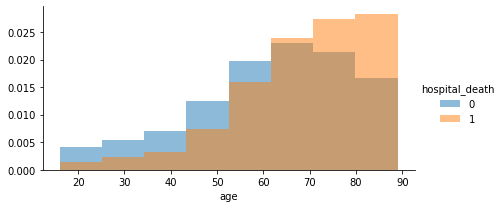

In [44]:
g = sns.FacetGrid(df, hue="hospital_death",height=3, aspect=2)
g.map(plt.hist, "age", density=True, bins=8, alpha=0.5)
g.set(xticks=[20,30,40,50,60,70,80,90])
g.add_legend();

> There is a high proportion of older patients admitted to ICU, especially >60 yrs.  Will it be better to categorize age?  
> Patients above 80yrs also seems to be at higher risk of not suriving.

In [ ]:
g = sns.FacetGrid(df, hue="hospital_death",height=3, aspect=2)
g.map(plt.hist, "pre_icu_los_days", density=True,alpha=0.7)
g.add_legend();

> Most of the deceased patients have very short stay in the hospital (from the hosptial admission to ICU admission)

In [ ]:
g = sns.FacetGrid(df, hue="hospital_death",height=3, aspect=2)
g.map(plt.hist, "bmi", density=True,alpha=0.6)
g.add_legend();

In [ ]:
g = sns.FacetGrid(df, hue="hospital_death",height=3, aspect=2)
g.map(plt.hist, "height", density=True,alpha=0.5)
g.add_legend();

In [ ]:
#df[df.hospital_death == 1]['height'].plot.hist(bins = 20, color='r')
#plt.show()
#df[df.hospital_death == 0]['height'].plot.hist(bins = 20,color='g')

In [ ]:
g = sns.FacetGrid(df, hue="hospital_death",height=3, aspect=2)
g.map(plt.hist, "apache_4a_icu_death_prob", density=True,alpha=0.5)
g.add_legend();

In [ ]:
sns.boxplot(x='hospital_death', y='apache_4a_icu_death_prob', data=df)

> Probablistic prediction of ICU mortality from APACHE system doesn't show good correlation with the actual hospital_death

In [ ]:
df['apache_3j_diagnosis'].value_counts()

In [ ]:
# The difference number of missing data between diagnosis and bodysystem is exactly the number of the invalid diagnosis
print(df.apache_3j_diagnosis.isnull().sum())
print(df.apache_3j_bodysystem.isnull().sum())
print(df.apache_2_bodysystem.isnull().sum())

In [ ]:
# 561 patients have invalid diagnosis code (<101), can't deduce which test it came from by looking at he decimal points alone
# Will treat them as NaN.

print(df[df['apache_3j_diagnosis']<101]['apache_3j_diagnosis'].value_counts())
df[df['apache_3j_diagnosis']<101]['apache_3j_diagnosis']

In [ ]:
# Set these invalid 561 'apache_3j_diagnosis' to NaN

index = [i for i in df.index if df.loc[i,'apache_3j_diagnosis']<101]
df.loc[index,'apache_3j_diagnosis'] = np.nan
df['apache_3j_diagnosis'].isnull().sum()

In [ ]:
# Missing data impute with fill(0)
# No codebook available to explain apache_2_diagnosis, for now will not consider this variable
# Create new varible to group patients by 3j diagnosis' main diagnosis (ignore the sub-diagnosis - decimals)
# Create new variable to group patients by 3j diagnosis' main diagnosis (by illness type - e.g 1xx, 11xx)?
# Create new variable to indicate if a patient has gone through operation (4 digits and starting at 1202: operative)
#                        use it to verify if variable apache_post_operative matches
#                        use it to verify if variable icu_admit_source matches


df['apache_3j_diag_int'] = df['apache_3j_diagnosis'].fillna(0).astype(str).map(lambda i: i.split('.')[0])
df['apache_3j_diag_type'] = df['apache_3j_diag_int'].map(lambda i: i[:-2])  # discard the last 2 digits
df['apache_3j_diag_operative'] = df['apache_3j_diag_int'].astype(int).map(lambda i: 1 if i>=1202 else 0)  # code >= 1202 is operative

df[df['apache_3j_diag_operative'] != df.apache_post_operative][['apache_post_operative','apache_3j_diagnosis','apache_3j_diag_int','apache_3j_diag_operative']]

> `apache_3j_diag_operative` matches `apache_post_operative`

#### Use `apache_post_operative` to deduce `icu_admit_source`

In [ ]:
print(df.icu_admit_source.astype(str).value_counts())
df[df['icu_admit_source'].isnull()][['icu_admit_source','apache_3j_diag_int','apache_3j_diag_operative']]

In [ ]:
df.loc[(df['apache_post_operative']==1) & (df['icu_admit_source'].isnull()),'icu_admit_source'] = 'Operating Room / Recovery'
print(df.icu_admit_source.astype(str).value_counts())

#### <font color='crimson'> Impute remaining Categorical Columns </font>

In [ ]:
# Impute the rest of the icu_admit_source with 'Unknown'
# Impute bodysystems and diagnosis with zero
df.icu_admit_source = df.icu_admit_source.fillna("Unknown")
df.apache_3j_bodysystem = df.apache_3j_bodysystem.fillna("Unknown")
df.apache_2_bodysystem = df.apache_2_bodysystem.fillna("Unknown")
df.apache_3j_diagnosis = df.apache_3j_diagnosis.fillna(0)
df.apache_2_diagnosis = df.apache_2_diagnosis.fillna(0)

In [ ]:
print(df.apache_3j_bodysystem.isnull().sum())
print(df.apache_3j_diagnosis.isnull().sum())

In [ ]:
# Check for missing data in categorical cols again
categorical_cols = [col for col in df.columns if  (df[col].dtype != 'float64')&(df[col].dtype != 'int64') ]
df[categorical_cols].isnull().sum()

## B. Vitals/labs Variables

### Rows with close to empty d1_ measurements

In [ ]:
print(len(h1_labs), len(d1_labs))
lab_cols = h1_labs + d1_labs

In [ ]:
temp = df[lab_cols]
df[temp.notnull().sum(axis=1)<3]

## <font color='RED'> Let's create a column that show the number of test a patients received later</font>

In [34]:
h1_cols = [col for col in df.columns if col.startswith("h1_")]
df[h1_cols].notnull().sum(axis=1)

0        20
1        54
2        20
3        38
4        16
         ..
91708    50
91709    20
91710     8
91711     0
91712    22
Length: 91713, dtype: int64

### Sanity check if data in '_max' col is always equal or larger than '_min'.  If they are not, fix it

In [47]:
#delta = (df['d1_sysbp_noninvasive_max'] - df["d1_sysbp_noninvasive_min"])
#index =delta[delta<0].index
#temp = df.loc[index,'d1_resprate_max']
#df.loc[index,['d1_sysbp_noninvasive_max','d1_sysbp_noninvasive_min'] ]

In [ ]:
#df.loc[index,'d1_resprate_max'] = df.loc[index,'d1_resprate_min']
#df.loc[index,'d1_resprate_min'] = temp
#df.loc[index,['d1_resprate_max','d1_resprate_min'] ]

In [36]:
cols = list(set([col[:-4] for col in df.columns if (col.endswith("_min"))| (col.endswith("_max"))]))
len(cols)

64

In [43]:
for col in cols:
    deta = []
    index = []
    temp = []
    min = col + "_min"
    max = col + "_max"
    delta = (df[max]-df[min])
    index = delta[delta<0].index
    if delta.min()<0:
        print(df.loc[index,[max,min]])
    temp = df.loc[index,max]
    df.loc[index,max] = df.loc[index,min]
    df.loc[index,min] = temp
    if delta.min()<0:
        print(df.loc[index,[max,min]])

       d1_resprate_max  d1_resprate_min
52067             14.0             20.0
71776             92.0             96.0
72737             14.0             25.0
73863             92.0            100.0
81314             14.0             18.0
       d1_resprate_max  d1_resprate_min
52067             20.0             14.0
71776             96.0             92.0
72737             25.0             14.0
73863            100.0             92.0
81314             18.0             14.0
       h1_hematocrit_max  h1_hematocrit_min
32846               16.0               51.5
58638               16.0               51.5
83239               16.0               51.5
88574               16.0               51.5
       h1_hematocrit_max  h1_hematocrit_min
32846               51.5               16.0
58638               51.5               16.0
83239               51.5               16.0
88574               51.5               16.0
       h1_arterial_ph_max  h1_arterial_ph_min
7887                 6.93         

85124             7.05428             7.41000
       d1_arterial_ph_max  d1_arterial_ph_min
1518              7.10000             7.05428
5103              7.36000             7.05428
6320              7.30000             7.05428
7001              7.53000             7.05428
17739             7.41800             7.05428
32224             7.15000             7.05428
32473             7.42000             7.05428
34138             7.43000             7.05428
36820             7.09000             7.05428
38971             7.49000             7.05428
40216             7.29000             7.05428
40675             7.36000             7.05428
42800             7.53700             7.05428
45674             7.55786             7.05428
46999             7.27000             7.05428
52015             7.12000             7.05428
57137             7.43000             7.05428
60638             7.41700             7.05428
61724             7.36000             7.05428
62570             7.20000         

91606                    60.0                    62.0
       d1_mbp_noninvasive_max  d1_mbp_noninvasive_min
405                      86.0                    60.0
3501                     92.0                    60.0
5444                     70.0                    60.0
5869                     82.0                    60.0
11941                    89.0                    60.0
12666                    95.0                    60.0
24229                    69.0                    60.0
32353                    63.0                    60.0
33582                   102.0                    60.0
33813                    75.0                    60.0
39688                    75.0                    60.0
45613                    82.0                    60.0
48798                    76.0                    60.0
59390                    81.0                    60.0
66489                    62.0                    60.0
71804                    80.0                    60.0
89314                    62.

85840               50.0               20.4
       h1_diasbp_max  h1_diasbp_min
4194            37.0           77.0
4324            37.0          113.0
6036            37.0          113.0
10861           37.0           60.0
20719           37.0           57.0
21114           37.0           64.0
21807           37.0           60.0
22062           37.0           79.0
23859           37.0           52.0
25963           37.0           96.0
32097           37.0           41.0
37046           37.0           74.0
39154           37.0          113.0
39516           37.0           83.0
44155           37.0          112.0
46568           37.0           71.0
46665           37.0           86.0
50624           37.0           87.0
55174           37.0           74.0
55381           37.0           80.0
56304           37.0           95.0
58357           37.0           43.0
63014           37.0          113.0
63701           37.0           56.0
67396           37.0          113.0
73563           37.0

> Noted some of the variables seem to have a default min/max, as the values are consistent across patients
> <font color='blue'> Verify them later </font>

       h1_hematocrit_max  h1_hematocrit_min
32846               16.0               51.5
h1_arterial_ph_min      6.93              
d1_temp_min             35.1
h1_temp_min             33.4  (75)
h1_sysbp_noninvasive_min 75.0
d1_mbp_invasive_min      38.0
d1_mbp_noninvasive_min   60.0
d1_mbp_min               60.0
d1_arterial_pco2_min   18.4
d1_diasbp_noninvasive_min    46.0
h1_diasbp_noninvasive_min    37.0
d1_sysbp_noninvasive_min     90.0
d1_sysbp_invasive_min        65.0
h1_diasbp_invasive_min       33.0
d1_diasbp_min                46.0
h1_diasbp_min                37.0
h1_sysbp_min                 75.0
d1_platelets_min       27.0
d1_arterial_ph_min     7.05428
       h1_calcium_max  h1_calcium_min
14600          11.315             5.6
d1_sodium_min         123.0
h1_potassium_min      2.5
h1_potassium_max      7.1 ? 
d1_hemaglobin_min     6.8
h1_hemaglobin_min     5.1
d1_albumin_min        1.2
d1_hco3_min           12.0
h1_mbp_min            49.0
h1_heartrate_min      46.0
d1_heartrate_min      58.0
d1_calcium_min        6.2
d1_hematocrit_min     20.4
d1_bun_min            4.0
d1_potassium_min      2.8

In [ ]:
df[d1_vitals].isnull().sum()

> comparison between h1 and d1: per measurement, h1 has more missing rows than d1
> Invasive data is more sparse than noninvasive
> Imputation doesn't make sense, as we are making up the measurement for patients if we do so.
> diasbp/sysbp/mbp's min/max are taken from invasive/noninvasive measurements

In [46]:
h1 = df[h1_vitals]
d1 = df[d1_vitals]
d1[d1.d1_sysbp_invasive_min.notnull()]

,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_temp_max,d1_temp_min
0,46.0,32.0,68.0,37.0,68.0,37.0,122.0,64.0,131.0,73.0,131.0,73.0,66.0,40.0,89.0,46.0,89.0,46.0,119.0,72.0,34.0,10.0,100.0,74.0,39.9,37.2
3,62.0,30.0,48.0,42.0,48.0,42.0,164.0,78.0,158.0,84.0,158.0,84.0,92.0,52.0,84.0,84.0,84.0,84.0,116.0,92.0,23.0,7.0,100.0,95.0,38.0,34.8
6,107.0,65.0,76.0,68.0,76.0,68.0,191.0,116.0,151.0,133.0,151.0,133.0,138.0,84.0,117.0,97.0,117.0,97.0,112.0,70.0,38.0,16.0,100.0,87.0,37.2,35.0
8,64.0,52.0,65.0,59.0,65.0,59.0,94.0,72.0,104.0,98.0,104.0,98.0,72.0,66.0,93.0,71.0,93.0,71.0,82.0,82.0,24.0,19.0,97.0,97.0,36.9,36.9
9,74.0,57.0,83.0,48.0,83.0,48.0,126.0,103.0,135.0,78.0,135.0,78.0,92.0,73.0,101.0,59.0,101.0,59.0,96.0,57.0,44.0,14.0,100.0,96.0,37.1,36.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91678,89.0,26.0,102.0,27.0,102.0,27.0,155.0,68.0,122.0,76.0,122.0,76.0,94.0,44.0,105.0,40.0,105.0,40.0,107.0,87.0,24.0,0.0,100.0,87.0,37.0,36.9
91685,119.0,5.0,115.0,20.0,115.0,20.0,228.0,154.0,156.0,60.0,156.0,60.0,151.0,106.0,130.0,40.0,130.0,40.0,148.0,82.0,22.0,6.0,100.0,90.0,36.6,36.6
91691,48.0,40.0,62.0,36.0,62.0,36.0,71.0,48.0,113.0,59.0,113.0,59.0,240.0,44.0,82.0,41.0,82.0,41.0,114.0,0.0,42.0,0.0,96.0,51.0,38.8,37.8
91695,102.0,67.0,100.0,64.0,100.0,64.0,195.0,116.0,175.0,100.0,175.0,100.0,137.0,88.0,114.0,76.0,114.0,76.0,100.0,61.0,24.0,12.0,100.0,97.0,37.0,36.2


> Visually inspected, for blood pressure, the mean (such as h1_sysbp_, d1_diasbp_, d1_mbp_) was taken from the noninvasive.

In [ ]:
# d1_diasbp
print("Number of rows of missing diasbp_max : ", len(d1[(d1.d1_diasbp_max.isnull())]))
print("Number of rows for missing diasbp measurments (all 6) : ",len(d1[(d1.d1_diasbp_max.isnull()) & (d1.d1_diasbp_min.isnull()) & 
   (d1.d1_diasbp_noninvasive_max.isnull()) & (d1.d1_diasbp_noninvasive_min.isnull())& 
   (d1.d1_diasbp_invasive_max.isnull()) & (d1.d1_diasbp_invasive_min.isnull())]))

# d1_sysbp
print("Number of rows of missing sysbp_max : ", len(d1[(d1.d1_sysbp_max.isnull())]))
print("Number of rows for missing sysbp measurments (all 6) : ",len(d1[(d1.d1_sysbp_max.isnull()) & (d1.d1_sysbp_min.isnull()) & 
   (d1.d1_sysbp_noninvasive_max.isnull()) & (d1.d1_sysbp_noninvasive_min.isnull())& 
   (d1.d1_sysbp_invasive_max.isnull()) & (d1.d1_sysbp_invasive_min.isnull())]))

# d1_mbp
print("Number of rows of missing mbp_max : ", len(d1[(d1.d1_mbp_max.isnull())]))
print("Number of rows for missing mbp measurments (all 6) : ",len(d1[(d1.d1_mbp_max.isnull()) & (d1.d1_mbp_min.isnull()) & 
   (d1.d1_mbp_noninvasive_max.isnull()) & (d1.d1_mbp_noninvasive_min.isnull())& 
   (d1.d1_mbp_invasive_max.isnull()) & (d1.d1_mbp_invasive_min.isnull())]))


# h1_diasbp
print("Number of rows of missing h1_diasbp_max : ", len(h1[(h1.h1_diasbp_max.isnull())]))
print("Number of rows for missing h1_diasbp measurments (all 6) : ",len(h1[(h1.h1_diasbp_max.isnull()) & (h1.h1_diasbp_min.isnull()) & 
   (h1.h1_diasbp_noninvasive_max.isnull()) & (h1.h1_diasbp_noninvasive_min.isnull())& 
   (h1.h1_diasbp_invasive_max.isnull()) & (h1.h1_diasbp_invasive_min.isnull())]))


> Missing data is systematic at diasbp/sysbp/mbp's min and max
> diasbp/sysbp/mbp's min and max are missing due to no measurements (noninvasive and invasive are both not available)

In [ ]:
print(h1[(h1.h1_diasbp_max == h1.h1_diasbp_noninvasive_max) & 
         (h1.h1_diasbp_min == h1.h1_diasbp_noninvasive_min)].shape)
print(h1[(h1.h1_diasbp_max == h1.h1_diasbp_invasive_max) & 
         (h1.h1_diasbp_min == h1.h1_diasbp_invasive_min)].shape)


In [ ]:
h1[(h1.h1_diasbp_max == h1.h1_diasbp_invasive_max) & (h1.h1_diasbp_min == h1.h1_diasbp_invasive_min) & 
   (h1.h1_diasbp_noninvasive_max.isnull()) & (h1.h1_diasbp_noninvasive_min.isnull())].shape

In [ ]:
h1[(h1.h1_diasbp_max == h1.h1_diasbp_invasive_max) & (h1.h1_diasbp_min == h1.h1_diasbp_invasive_min) & 
   (h1.h1_diasbp_noninvasive_max.notnull()) & (h1.h1_diasbp_noninvasive_min.notnull())].shape

In [ ]:
82863+4400, 3686 + 714

> Majority ofth mean bp come from noninvasive measurement, 
> Minority come from invasive, which is largely due to missing data in the noninvasive cols

#### for those reading taken from invasive, while noninvasive is still present, why noninvasive reading is not taken into account?

It seems that some were taken correctly (choose the highest from noninvasive/invasive), some were wrong (human error?)

In [ ]:
# mean bp taken from invasive while noninvasive meausurements are still present
# it seems that the the noninvasive measurement is not complete
h1[(h1.h1_diasbp_max == h1.h1_diasbp_invasive_max) & (h1.h1_diasbp_min== h1.h1_diasbp_invasive_min) & 
   (h1.h1_diasbp_noninvasive_max.notnull()) & (h1.h1_diasbp_noninvasive_min.notnull())]

In [ ]:
h1[(h1.h1_diasbp_max == h1.h1_diasbp_invasive_max) & (h1.h1_diasbp_min== h1.h1_diasbp_invasive_min) & 
   (h1.h1_diasbp_noninvasive_max.notnull()) & (h1.h1_diasbp_noninvasive_min.notnull())][h1.h1_diasbp_noninvasive_max != h1.h1_diasbp_noninvasive_min]

### How well does the calculated MAP compared to the data?
#### MAP = (sbp + 2*dbp)/3 for each of the 6 measurements

In [ ]:
temp = df[d1_vitals]
temp['map_max'] = (temp['d1_sysbp_max'] + 2*temp['d1_diasbp_max'])/3
diff_max = temp['d1_mbp_max'] - temp['map_max']

map_min = (df['d1_sysbp_min'] + 2*df['d1_diasbp_min'])/3
diff_min = df['d1_mbp_min'] - map_min

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y=diff_min, x=df['d1_mbp_min'],alpha=0.5)
plt.axhline(0, color = "g", linestyle = 'dashed')
plt.ylabel("Difference")
plt.xlabel("Actual d1_mbp_min")

plt.figure(figsize=(8,8))
plt.scatter(y=diff_max, x=df['d1_mbp_max'],alpha=0.5)
plt.axhline(0, color = "g", linestyle = 'dashed')
plt.ylabel("Difference")
plt.xlabel("Actual d1_mbp_max")

#plt.figure(figsize=(8,8))
#plt.scatter(map_max, df['d1_mbp_max'],alpha=0.5)
#plt.xlabel("Calucated Day 1 Mean Arterial Pressure (Max)")
#plt.ylabel("Actual d1_mbp_max")


>>The calculated value doesn't seem to be a very good fit

In [ ]:
#plt.figure(figsize=(20,6))
#plt.plot(df[['d1_diasbp_max','d1_sysbp_max', 'd1_mbp_max']],alpha=0.5)
#plt.show()

plt.figure(figsize=(20,6))
plt.plot(temp[['d1_mbp_max', 'map_max']],alpha=0.5)
plt.show()

In [ ]:
#plt.figure(figsize=(20,6))
#plt.plot(df[['h1_diasbp_invasive_max','h1_diasbp_invasive_min']],alpha=0.5)
#plt.show()
#plt.figure(figsize=(20,6))
#plt.plot(df[['h1_diasbp_max','h1_diasbp_min']],alpha=0.5)
#plt.show()
#plt.figure(figsize=(20,6))
#plt.plot(df[['h1_diasbp_noninvasive_max','h1_diasbp_noninvasive_min']],alpha=0.5)

### c. h1 and d1 Labs

In [ ]:
h1_labs_df = df[h1_labs]
d1_labs_df = df[d1_labs]

In [ ]:
h1_labs_df.isnull().sum()

In [ ]:
d1_labs_df.isnull().sum()

### d. h1 and d1 lbg

In [ ]:
h1_lbg_df = df[h1_lbg]
d1_lbg_df = df[d1_lbg]

In [ ]:
h1_lbg_df.isnull().sum()

In [ ]:
d1_lbg_df.isnull().sum()

### e. Apache covariates columns
* Missing Apache Covariates can be imputed based on the codebook instruction, but it's going to be a very tedious process
* And it won't impute all missing rows - only if h1_, and d1_ data is available - <font color = "crimson">so we still have a lot of them missing</font>
* What's the point of reconstrucing the Apache reading, while most of them arealready in the h1_, d1_ variables?
* Instead, <font color = "crimson">reconstructing Apache score may be more meaningful for prediction</font> - they can be provided with the dataset but wasn't, why?
* If you compute the Apache score, you're actually following the APACHE 3j scoring system to rank a patient, then how is this prediction different from the already established scoring system?  
         - It's different in the sense of the formula
         - It means you recogize the usefulness of the score, and use them as part of the predictors
* <font color='green'>__Will come back and work on the score construction if time permits, skip for now__</font>

In [ ]:
print(len(apache_cov))
apache_cov_df = df[apache_cov]
apache_cov_df.isnull().sum()

### Missing data by datatype - Binary

In [ ]:
### Binary Features
bi_cols = ['hospital_death','elective_surgery','gcs_unable_apache'] + apache_indicators + apache_chronic
print(len(bi_cols))

In [ ]:
#from collections import Counter
#for col in bi_cols:
#        print(col, Counter(df[col].astype(str)).keys())

In [ ]:
for col in bi_cols:
    print(df[col].astype(str).value_counts())
    print()

In [ ]:
df.elective_surgery.value_counts(normalize=True)

In [ ]:
df.apache_post_operative.value_counts(normalize=True)

> Missing values can be treated in two categories:
* Interestingly, Apache related columns have the same number of missing rows: 715. That means they could come from the same patients
* gcs_unable_apache has 1037 missing rows

> `apache_post_operative`: 20% of patients were post_operative 

> `elective_surgery`: 18.4% of the patients was admitted to the hospital for an elective surgical operation

In [ ]:
# check if patients were systematically missing these info
df[(df.arf_apache.isnull()) & (df.intubated_apache.isnull()) & (df.ventilated_apache.isnull()) & 
   (df.aids.isnull()) & (df.cirrhosis.isnull()) & (df.diabetes_mellitus.isnull()) & (df.hepatic_failure.isnull()) & 
   (df.immunosuppression.isnull()) & (df.leukemia.isnull()) & (df.lymphoma.isnull()) & (df.solid_tumor_with_metastasis.isnull())]

# 715 rows returned, so they are missing apache data systematically

In [ ]:
null_apache_indicators = df[(df.arf_apache.isnull()) & (df.intubated_apache.isnull()) & (df.ventilated_apache.isnull()) & 
   (df.aids.isnull()) & (df.cirrhosis.isnull()) & (df.diabetes_mellitus.isnull()) & (df.hepatic_failure.isnull()) & 
   (df.immunosuppression.isnull()) & (df.leukemia.isnull()) & (df.lymphoma.isnull()) & (df.solid_tumor_with_metastasis.isnull())]

null_apache_indicators[apache].isnull().sum()

> Confirmed that these patients are missing all APACHE measurements except the diagnosis and bodysystem. 
> <font size = 3 color = "crimson">Come back to address APACHE later</font>

#### for gcs_unable_apache == NaN

In [ ]:
# check if all gcs columns are systematic missing data
df[(df.gcs_unable_apache.isnull()) & 
   (df.gcs_eyes_apache.isnull()) & 
   (df.gcs_motor_apache.isnull()) & 
   (df.gcs_verbal_apache.isnull())].shape

> the number of patients with gcs_unable_apache = NaN is the same as those with eye/motor/verbal all missing
> It seems like these 1037 patients are under sedation (hence couldn't get GCS assessed).  Code below to verify this suspection

In [ ]:
# For patients under sedation (gcs_unable_apache==1), are their eyes/motor/verbal scores all missing? 
sedated= df[df.gcs_unable_apache==1]
print(len(sedated))
print(len(sedated[(sedated.gcs_eyes_apache.isnull()) & 
                  (sedated.gcs_motor_apache.isnull()) & 
                  (sedated.gcs_verbal_apache.isnull())]))

> Yes, eyes/motor/verbal scores are all missing for sedated patients 

In [ ]:
# For non-sedated patients(gcs_unable_apache==0), is there any missing data in eyes/motor/verbal scores? 
nonsedated= df[df.gcs_unable_apache==0]
print(len(nonsedated))
print(len(nonsedated[(nonsedated.gcs_eyes_apache.isnull()) | 
                  (nonsedated.gcs_motor_apache.isnull()) |
                  (nonsedated.gcs_verbal_apache.isnull())]))

> No, eyes/motor/verbal scores are all available for non-sedated patients 

> So we should treat these 1037 patients as sedated ones

In [ ]:
# Before
print(df.gcs_unable_apache.astype(str).value_counts())

# Fill the missing rows with 1
df.gcs_unable_apache.fillna('1.0',inplace=True)

# After
print(df.gcs_unable_apache.astype(str).value_counts())

In [ ]:
#df.gcs_eyes_apache.astype(str).value_counts()
# GCS eyes have 4 ordinal values

In [ ]:
#df.gcs_motor_apache.astype(str).value_counts()
# GCS motor has 6 ordinal values

In [ ]:
#df.gcs_verbal_apache.astype(str).value_counts()
# GCS verbal has 5 ordinal values

## 5. Correlated Features

In [ ]:
df_corr = df.drop('hospital_death', axis=1).corr().abs()

In [ ]:
# Upper triangle of correlations
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
upper.head(20)

#### Find Features with correlation higher than threshold

In [ ]:
threshold = 0.9
col_to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
print(len(col_to_drop))
upper[col_to_drop]

In [ ]:
for col in col_to_drop:
    col_corr = upper[col].sort_values(ascending=False)
    print(col)
    print(col_corr.head())

> lots of variables are highly corrected to each other, expected, as they are measuring the same test

In [ ]:
df[['d1_albumin_max', 'd1_albumin_min']].plot()

### Checkpoint

In [ ]:
# New variables are:
set(df.columns).difference(set(train.columns))

In [ ]:
test_cols = [col for col in df.columns if col.startswith('h1_') | col.startswith('d1_')]
print(len(test_cols))

In [ ]:
print(df.shape)
df[bi_cols].isnull().sum()

In [ ]:
df[test_cols].isnull().sum()

In [ ]:
df[apache].isnull().sum()

### Fill test_cols and apache with 0

In [ ]:
df[bi_cols] = df[bi_cols].fillna(0)
df[test_cols] = df[test_cols].fillna(0)
df[apache] = df[apache].fillna(0)

In [ ]:
df.isnull().sum().sort_values(ascending=False)

### Save the dataframe

In [ ]:
df = df.drop(columns=['apache_3j_diag_int', 'admit_flow','apache_3j_diag_operative','apache_3j_diag_type'])

In [ ]:
df = df.drop("admit_flow",axis=1)

In [ ]:
df.shape

In [ ]:
df.to_csv('../data/train_clean.csv', index=False)